In [256]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


__0 experiment:__

$f(x)=x$

$\hat{f}(x)=a_0 + a_1x + a_2x^2 + a_3x^3 + a_4x^4 + \dots$

points from uniform distribution from $[-2, 2]$

In [347]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import uniform

In [314]:
class Net(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(Net, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out


net = Net(1, 1)

In [398]:
def learn(x, y, criterion, model, optimizer, verbose=False, epochs=500):
    inputs = Variable(torch.from_numpy(x))
    labels = Variable(torch.from_numpy(y))
    for epoch in range(epochs):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

    if verbose:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

In [399]:
def get_mean_l2_norm(size=50, p_count=5, regressor=None, params=None, verbose=False, **kwargs):
    SIZE = size
    P_COUNT = p_count
    
    if regressor is None:
        regressor = LinearRegression
        params = {}
    
    def f(x):
        return x
    def P(x, n):
        return np.power(x, n)
    def d_P(x, n):
        if n == 0:
            return 0
        return n * np.power(x, n - 1)
    def f_model_with_grad(x, coef):
        return np.sum([coef[i] * P(x, i) for i in range(P_COUNT)])
    def f_model_no_grad(x, coef):
        return np.sum([coef[i] * P(x, i) for i in range(P_COUNT)])
    def d_f(x):
        return 1
    
    mean_with_grad = []
    mean_no_grad = []
    for i in range(1):
        points = np.random.uniform(low=-2, high=2, size=SIZE)
        xs = points
        F_with_grad = np.array([f(x) for x in xs] + [d_f(x) for x in xs], dtype=np.float32).reshape(-1, 1)
        F_no_grad = np.array([f(x) for x in xs], dtype=np.float32).reshape(-1, 1)
        A_with_grad = np.array(
            [[P(x, i) for i in range(P_COUNT)] for x in xs] + [[d_P(x, i) for i in range(P_COUNT)] for x in xs], dtype=np.float32).reshape(-1, P_COUNT)
        A_no_grad = np.array([[P(x, i) for i in range(P_COUNT)] for x in xs], dtype=np.float32).reshape(-1, P_COUNT)
        r_with_grad = Net(P_COUNT, 1)
        r_no_grad = Net(P_COUNT, 1)
        
        criterion_with_grad = torch.nn.MSELoss() 
        optimizer_with_grad = torch.optim.SGD(r_with_grad.parameters(), lr=1e-2)
        
        criterion_no_grad = torch.nn.MSELoss() 
        optimizer_no_grad = torch.optim.SGD(r_no_grad.parameters(), lr=1e-2)
        
        learn(A_with_grad, F_with_grad, criterion_with_grad, r_with_grad, optimizer_with_grad, verbose)
        learn(A_no_grad, F_no_grad, criterion_no_grad, r_no_grad, optimizer_no_grad, verbose)

        def f_model_with_grad(x):
            if verbose:
                print('with grad weights', r_with_grad.linear.weight)
            return r_with_grad(x)

        def f_model_no_grad(x):
            if verbose:
                print('no grad weights', r_no_grad.linear.weight)
            return r_no_grad(x)

        test_points = np.random.uniform(low=-2, high=2, size=SIZE)
        test_xs = test_points
        A_test = Variable(torch.from_numpy(np.array([[P(x, i) for i in range(P_COUNT)] for x in test_xs], dtype=np.float32).reshape(-1, P_COUNT)))
#         print(np.arraf_model_with_grad(A_test).detach().numpy() - np.array([f(x) for x in test_xs]))
#         print(f_model_no_grad(A_test).detach().numpy() - np.array([f(x) for x in test_xs]))
        mean_with_grad.append(
            np.linalg.norm(np.array([f(x) for x in test_xs]) - f_model_with_grad(A_test).detach().numpy().flatten()))
        mean_no_grad.append(
            np.linalg.norm(np.array([f(x) for x in test_xs]) - f_model_no_grad(A_test).detach().numpy().flatten()))
    if verbose:
        print('------------------------------------------------------------------------------------')
    return np.mean(mean_with_grad), np.mean(mean_no_grad), np.var(mean_with_grad), np.var(mean_no_grad)

In [379]:
experiments = [(15, 1), (2, 2), (5, 2), (50, 4), (50, 5), (50, 20), (50, 50), (200, 5), (200, 50)]
experiments = [(15, 2), (200, 2), (30, 3), (200, 5), (200, 7)]
for exp in experiments:
    print('\nsample size=%d, max order=%d' % exp)
    mean_with_grad, mean_no_grad, var_with_grad, var_no_grad = get_mean_l2_norm(*exp, verbose=True)
    print('\tmean: %f, variance: %f - with gradient\n\tmean: %f, variance: %f - no gradient' % (
        mean_with_grad, var_with_grad, mean_no_grad, var_no_grad))


sample size=15, max order=2
epoch 499, loss 5.998047640787263e-07
epoch 499, loss 7.271814261855525e-09
with grad weights Parameter containing:
tensor([[0.0011, 0.9998]], requires_grad=True)
no grad weights Parameter containing:
tensor([[7.4074e-05, 9.9995e-01]], requires_grad=True)
------------------------------------------------------------------------------------
	mean: 0.004283, variance: 0.000000 - with gradient
	mean: 0.000365, variance: 0.000000 - no gradient

sample size=200, max order=2
epoch 499, loss 6.225964170880616e-06
epoch 499, loss 7.981436345172455e-11
with grad weights Parameter containing:
tensor([[0.0035, 0.9998]], requires_grad=True)
no grad weights Parameter containing:
tensor([[-8.7438e-06,  1.0000e+00]], requires_grad=True)
------------------------------------------------------------------------------------
	mean: 0.050021, variance: 0.000000 - with gradient
	mean: 0.000123, variance: 0.000000 - no gradient

sample size=30, max order=3
epoch 499, loss 6.612105

In [377]:
def plot_l2_mean(polynom_count, sample_size=200, regressor=None, params=None):
    mean_with_grad_res = []
    mean_no_grad_res = []
    var_with_grad_res = []
    var_no_grad_res = []
    p_counts = np.arange(1, polynom_count, 1)
    for p_count in p_counts:
        print(p_count, end=',')
        mean_with_grad, mean_no_grad, var_with_grad, var_no_grad = get_mean_l2_norm(
                                                sample_size, p_count, regressor, params)
        mean_with_grad_res.append(mean_with_grad)
        mean_no_grad_res.append(mean_no_grad)
        var_with_grad_res.append(var_with_grad)
        var_no_grad_res.append(var_no_grad)

    plt.title('Mean norm. Variances are big')
    plt.plot(p_counts, mean_with_grad_res, label='with grad')
    plt.plot(p_counts, mean_no_grad_res, label='no grad')
    plt.xlabel('max polynom degree')
    plt.ylabel('mean l2-norm')
    plt.legend()

1,2,3,4,5,

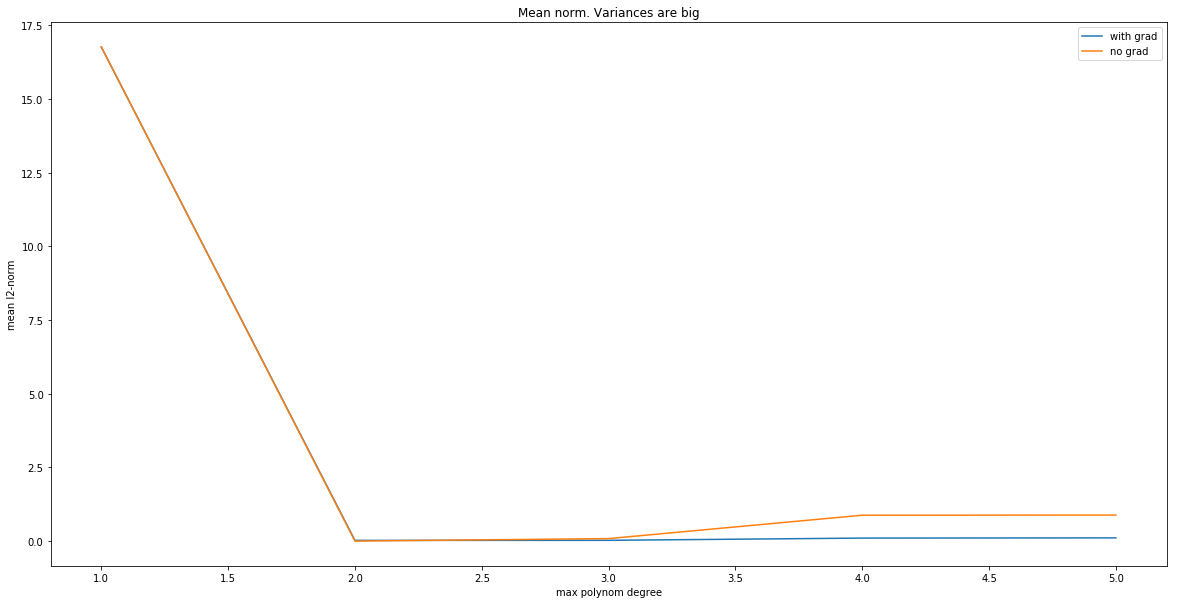

In [378]:
plt.figure(figsize=(20,10))
# plt.subplot(1, 2, 1)
# plot_l2_mean(100)
# plt.subplot(1, 2, 2)
plot_l2_mean(6)
plt.show()

__1 experiment:__

$f(x)=sin(x) + cos(x)$

$\hat{f}(x)=a_0 + a_1x + a_2x^2 + a_3x^3 + a_4x^4 + \dots$

points from uniform distribution from $[-2, 2]$

In [56]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [380]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import accuracy_score

In [403]:
def get_mean_l2_norm(size=50, p_count=5, regressor=None, params=None, verbose=False, epochs=500, lr=1e-2):
    SIZE = size
    P_COUNT = p_count
    
    if regressor is None:
        regressor = LinearRegression
        params = {}
    
    def f(x):
        return np.sin(x) + np.cos(x)
    def P(x, n):
        return np.power(x, n)
    def d_P(x, n):
        if n == 0:
            return 0
        return n * np.power(x, n - 1)
    def d_f(x):
        return np.cos(x) - np.sin(x)
    def f_taylor(size):
        if size == 0:
            return []
        ans = [1]
        for i in range(1, size):
            ans.append(ans[-1] / i)
            if i % 4 in [2, 3]:
                ans[-1] *= -1
        return ans
    
    mean_with_grad = []
    mean_no_grad = []
    mean_with_grad_taylor = []
    mean_no_grad_taylor = []
    for i in range(100):
        points = np.random.uniform(low=-2, high=2, size=SIZE)
        xs = points
        F_with_grad = np.array([f(x) for x in xs] + [d_f(x) for x in xs], dtype=np.float32).reshape(-1, 1)
        F_no_grad = np.array([f(x) for x in xs], dtype=np.float32).reshape(-1, 1)
        A_with_grad = np.array(
            [[P(x, i) for i in range(P_COUNT)] for x in xs] + [[d_P(x, i) for i in range(P_COUNT)] for x in xs], dtype=np.float32).reshape(-1, P_COUNT)
        A_no_grad = np.array([[P(x, i) for i in range(P_COUNT)] for x in xs], dtype=np.float32).reshape(-1, P_COUNT)
        r_with_grad = Net(P_COUNT, 1)
        r_no_grad = Net(P_COUNT, 1)
        
        criterion_with_grad = torch.nn.MSELoss() 
        optimizer_with_grad = torch.optim.SGD(r_with_grad.parameters(), lr=lr)
        
        criterion_no_grad = torch.nn.MSELoss() 
        optimizer_no_grad = torch.optim.SGD(r_no_grad.parameters(), lr=lr)
        
        learn(A_with_grad, F_with_grad, criterion_with_grad, r_with_grad, optimizer_with_grad, verbose=verbose, epochs=epochs)
        learn(A_no_grad, F_no_grad, criterion_no_grad, r_no_grad, optimizer_no_grad, verbose=verbose, epochs=epochs)
        
        def f_model_with_grad(x):
            if verbose:
                print('with grad weights', r_with_grad.linear.weight)
            return r_with_grad(x)

        def f_model_no_grad(x):
            if verbose:
                print('no grad weights', r_no_grad.linear.weight)
            return r_no_grad(x)
        
        test_points = np.random.uniform(low=-2, high=2, size=SIZE)
        test_xs = test_points
        A_test = Variable(torch.from_numpy(np.array([[P(x, i) for i in range(P_COUNT)] for x in test_xs], dtype=np.float32).reshape(-1, P_COUNT)))
#         print(np.arraf_model_with_grad(A_test).detach().numpy() - np.array([f(x) for x in test_xs]))
#         print(f_model_no_grad(A_test).detach().numpy() - np.array([f(x) for x in test_xs]))
        mean_with_grad.append(
            np.linalg.norm(np.array([f(x) for x in test_xs]) - f_model_with_grad(A_test).detach().numpy().flatten()))
        mean_no_grad.append(
            np.linalg.norm(np.array([f(x) for x in test_xs]) - f_model_no_grad(A_test).detach().numpy().flatten()))
        
        coefs = r_with_grad.linear.weight.detach().numpy()
        mean_with_grad_taylor.append(
            np.linalg.norm(np.array(f_taylor(P_COUNT)) - coefs))
        coefs = r_no_grad.linear.weight.detach().numpy()
        mean_no_grad_taylor.append(
            np.linalg.norm(np.array(f_taylor(P_COUNT)) - coefs))
        
    if verbose:
        print('------------------------------------------------------------------------------------')
        
    return (np.mean(mean_with_grad), np.mean(mean_no_grad),
            np.var(mean_with_grad), np.var(mean_no_grad),
            np.mean(mean_with_grad_taylor), np.mean(mean_no_grad_taylor),
            np.var(mean_with_grad_taylor), np.var(mean_no_grad_taylor))

In [404]:
experiments = [(2, 1), (2, 2), (5, 2), (50, 4), (50, 5), (50, 20), (50, 50)]
for exp in experiments:
    print('sample size=%d, max order=%d' % exp)
    stats =  get_mean_l2_norm(*exp)
    mean_with_grad, mean_no_grad, var_with_grad, var_no_grad = stats[:4]
    mean_with_grad_taylor, mean_no_grad_taylor, var_with_grad_taylor, var_no_grad_taylor = stats[4:]
    template = ('\tmean: %f, variance: %f - with gradient\n'
                '\tmean: %f, variance: %f - no gradient\n'
                '\ttaylor mean: %f, variance: %f - with gradient\n'
                '\ttaylor mean: %f, variance: %f - no gradient')
    print(template % stats)

sample size=2, max order=1
	mean: 1.437922, variance: 1.440485 - with gradient
	mean: 0.475154, variance: 0.477977 - no gradient
	taylor mean: 0.646435, variance: 0.647329 - with gradient
	taylor mean: 0.244931, variance: 0.245673 - no gradient
sample size=2, max order=2
	mean: 0.943334, variance: 0.932114 - with gradient
	mean: 0.584159, variance: 0.500830 - no gradient
	taylor mean: 0.596223, variance: 0.657412 - with gradient
	taylor mean: 0.186117, variance: 0.175193 - no gradient
sample size=5, max order=2
	mean: 1.317572, variance: 1.264862 - with gradient
	mean: 0.374740, variance: 0.390972 - no gradient
	taylor mean: 0.627289, variance: 0.586064 - with gradient
	taylor mean: 0.078372, variance: 0.080389 - no gradient
sample size=50, max order=4
	mean: 0.479663, variance: 0.621288 - with gradient
	mean: 0.005783, variance: 0.035067 - no gradient
	taylor mean: 0.358872, variance: 0.349007 - with gradient
	taylor mean: 0.000128, variance: 0.000623 - no gradient
sample size=50, max

In [402]:
def plot_l2_mean(polynom_count, sample_size=200, regressor=None, params=None, iterations_cnt=200, lr=1e-2):
    mean_with_grad_res = []
    mean_no_grad_res = []
    var_with_grad_res = []
    var_no_grad_res = []
    mean_with_grad_res_taylor = []
    mean_no_grad_res_taylor = []
    var_with_grad_res_taylor = []
    var_no_grad_res_taylor = []
    p_counts = np.arange(1, polynom_count)
    for p_count in p_counts:
        print(p_count, end=',')
        stats = get_mean_l2_norm(sample_size, p_count, regressor, params, iterations_cnt, lr)
        mean_with_grad, mean_no_grad, var_with_grad, var_no_grad = stats[:4]
        mean_with_grad_taylor, mean_no_grad_taylor, var_with_grad_taylor, var_no_grad_taylor = stats[4:]
        mean_with_grad_res.append(mean_with_grad)
        mean_no_grad_res.append(mean_no_grad)
        var_with_grad_res.append(var_with_grad)
        var_no_grad_res.append(var_no_grad)
        
        mean_with_grad_res_taylor.append(mean_with_grad_taylor)
        mean_no_grad_res_taylor.append(mean_no_grad_taylor)
        var_with_grad_res_taylor.append(var_with_grad_taylor)
        var_no_grad_res_taylor.append(var_no_grad_taylor)

    plt.figure(figsize=(20,20))
    plt.subplot(2, 2, 1)
    plt.title('Mean norm')
    plt.plot(p_counts, mean_with_grad_res, label='with grad')
    plt.plot(p_counts, mean_no_grad_res, label='no grad')
    plt.plot(p_counts, mean_with_grad_res_taylor, label='with grad taylor')
    plt.plot(p_counts, mean_no_grad_res_taylor, label='no grad taylor')
    plt.xlabel('max polynom degree')
    plt.ylabel('mean l2-norm')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.title('Mean norm')
    plt.plot(p_counts[:8], mean_with_grad_res[:8], label='with grad')
    plt.plot(p_counts[:8], mean_no_grad_res[:8], label='no grad')
    plt.plot(p_counts[:8], mean_with_grad_res_taylor[:8], label='with grad taylor')
    plt.plot(p_counts[:8], mean_no_grad_res_taylor[:8], label='no grad taylor')
    plt.xlabel('max polynom degree')
    plt.ylabel('mean l2-norm')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.title('Mean norm')
    plt.plot(p_counts, mean_with_grad_res, label='with grad')
    plt.plot(p_counts, mean_with_grad_res_taylor, label='with grad taylor')
    plt.plot(p_counts, mean_no_grad_res_taylor, label='no grad taylor')
    plt.xlabel('max polynom degree')
    plt.ylabel('mean l2-norm')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.title('Taylor norm')
    plt.plot(p_counts, mean_with_grad_res_taylor, label='with grad taylor')
    plt.plot(p_counts, mean_no_grad_res_taylor, label='no grad taylor')
    plt.xlabel('max polynom degree')
    plt.ylabel('mean l2-norm')
    plt.legend()
    
    plt.show()

1,2,3,4,

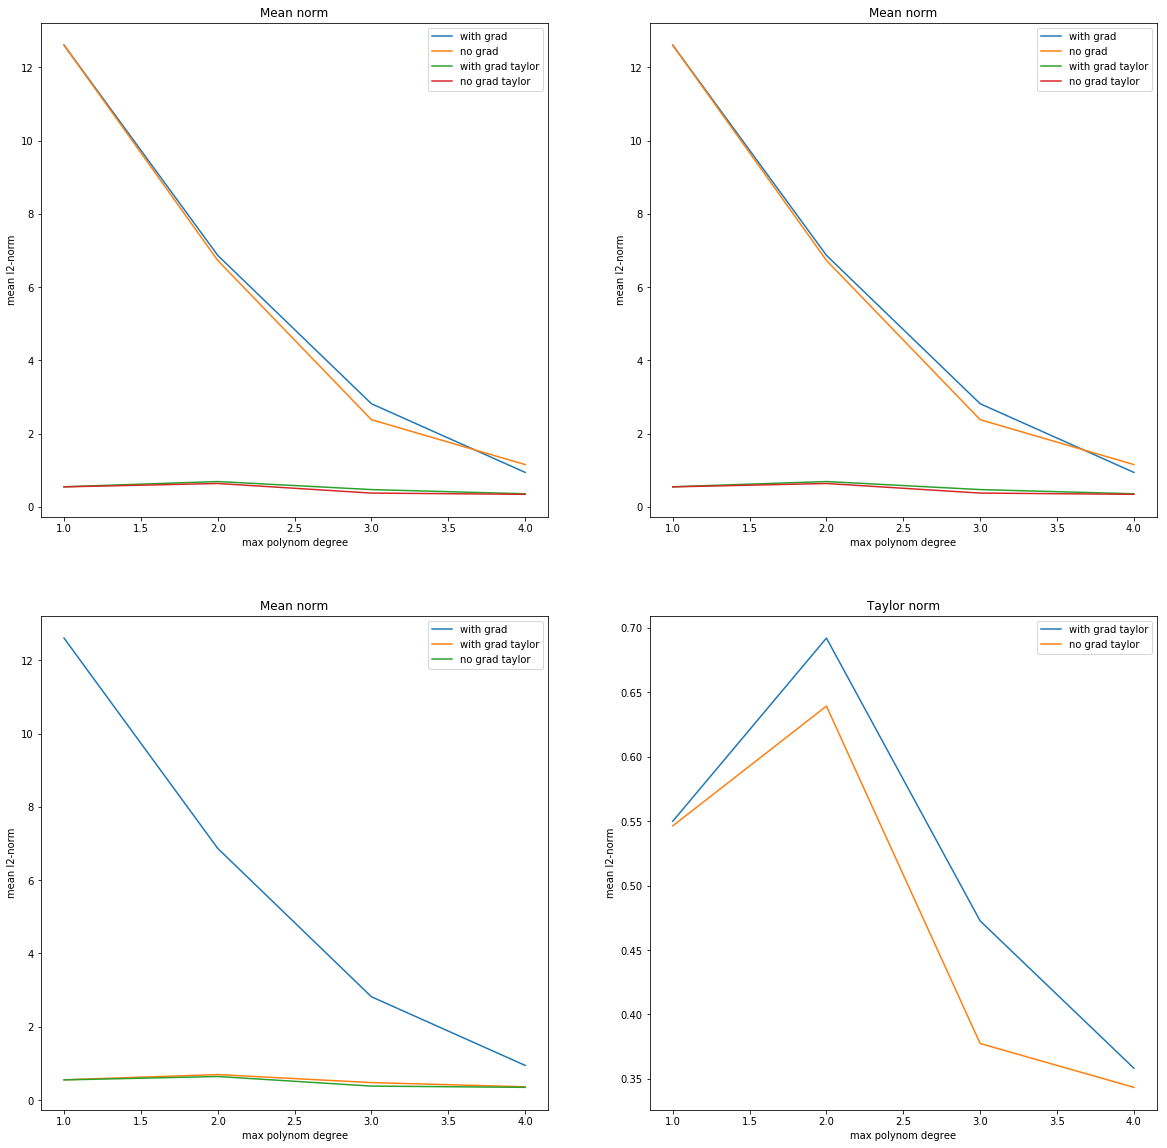

In [393]:
plot_l2_mean(5)

1,2,3,4,5,6,7,8,9,

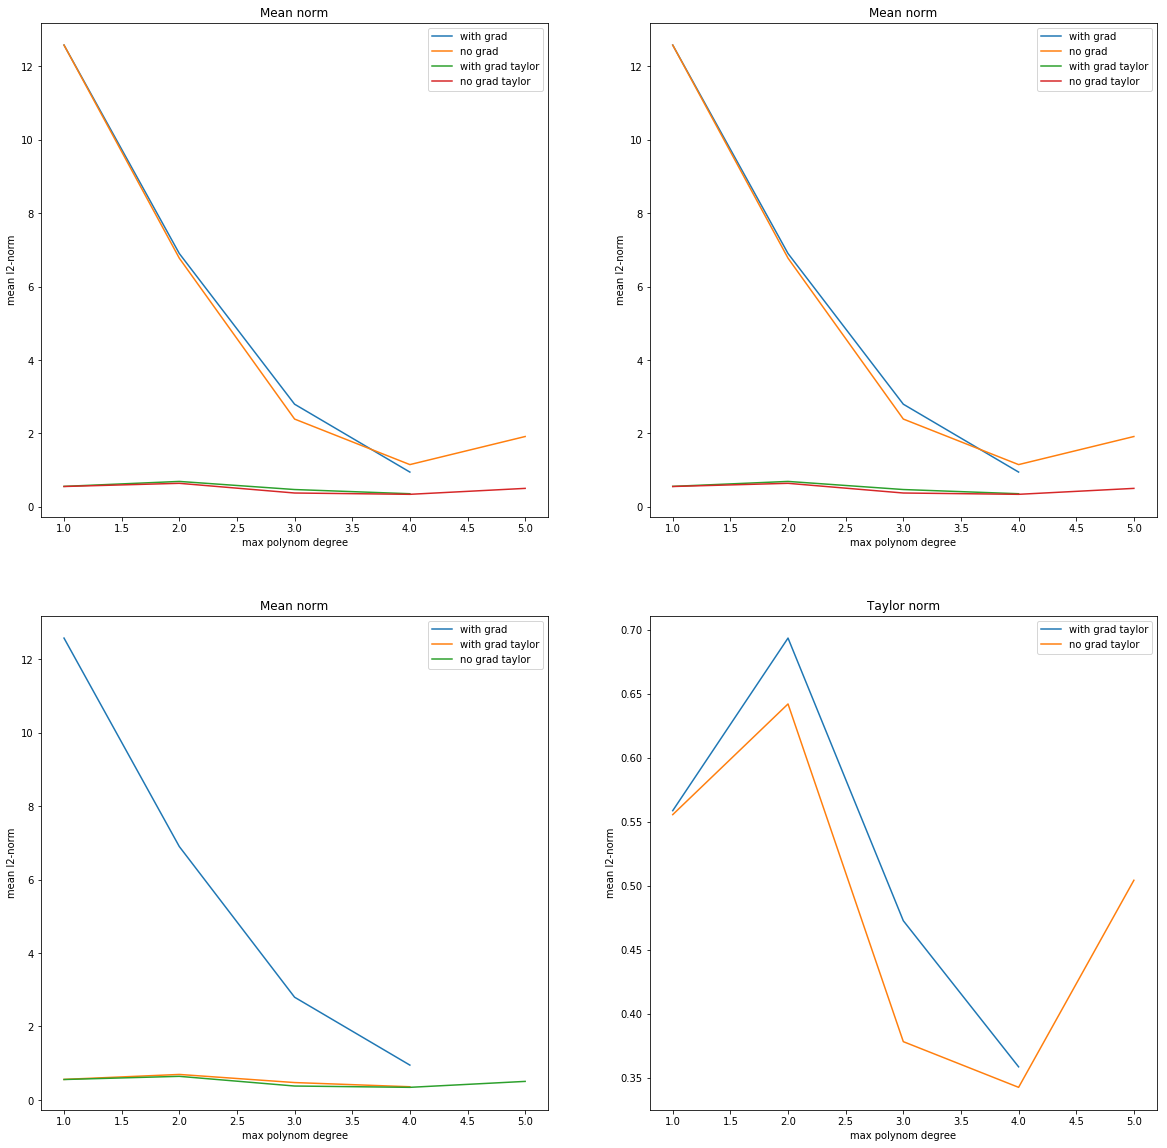

In [394]:
plot_l2_mean(10, )

__2 experiment:__

$f(x)=exp(-x_1^2 - 0.5(x_2 - 1)x_2)$

$\hat{f}(x)$ - linear combination of Chebyshev polynomials/their miltiplication

points from uniform distribution from $[-2, 2] \times [-2, 2]$

In [5]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import accuracy_score

In [13]:
def f(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2)

def d_f1(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2) * (-2*x1)

def d_f2(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2) * (-x2 + 0.5)

def P(x, n):
    if n == 0:
        return 1
    if n == 1:
        return x
    return 2 * x * P(x, n - 1) - P(x, n - 2)

def d_P(x, n):
    if n == 0:
        return 0
    if n == 1:
        return 1
    return 2 * x * d_P(x, n - 1) + 2 * P(x, n - 1) - d_P(x, n - 2)

In [14]:
def build_P_polynoms():
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(lambda x1, x2: P(x1, deg))
        P_polynoms.append(lambda x1, x2: P(x2, deg))
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(lambda x1, x2: P(x1, first_monom_deg) * P(x2, deg - first_monom_deg))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(lambda x1, x2: P(x1, deg - first_monom_deg) * P(x2, first_monom_deg))
    return P_polynoms

def build_d1_P_polynoms():
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(lambda x1, x2: d_P(x1, deg))
        P_polynoms.append(lambda x1, x2: 0)
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(lambda x1, x2: d_P(x1, first_monom_deg) * P(x2, deg - first_monom_deg))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(lambda x1, x2: d_P(x1, deg - first_monom_deg) * P(x2, first_monom_deg))
    return P_polynoms

def build_d2_P_polynoms():
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(lambda x1, x2: 0)
        P_polynoms.append(lambda x1, x2: d_P(x2, deg))
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(lambda x1, x2: P(x1, first_monom_deg) * d_P(x2, deg - first_monom_deg))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(lambda x1, x2: P(x1, deg - first_monom_deg) * d_P(x2, first_monom_deg))
    return P_polynoms

In [15]:
P_polynoms = build_P_polynoms()
d1_P_polynoms = build_d1_P_polynoms()
d2_P_polynoms = build_d2_P_polynoms()

In [24]:
def get_mean_l2_norm(size=50, p_count=5):
    SIZE = size
    P_COUNT = p_count
    
    mean_with_grad = []
    mean_no_grad = []
    for i in range(50):
        points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        x1s = points[:,0]
        x2s = points[:,1]
        F_with_grad = np.array(
            [f(p[0], p[1]) for p in points] + \
            [d_f1(p[0], p[1]) for p in points] + \
            [d_f2(p[0], p[1]) for p in points])
        F_no_grad = np.array([f(p[0], p[1]) for p in points])
        A_with_grad = np.array(
            [[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points] + \
            [[d1_P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points] + \
            [[d2_P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points])
        A_no_grad = np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points])
        r_with_grad = LinearRegression()
        r_no_grad = LinearRegression()
        r_with_grad.fit(A_with_grad, F_with_grad)
        r_no_grad.fit(A_no_grad, F_no_grad)
        def f_model_with_grad(x1, x2):
            return np.sum([r_with_grad.coef_[i] * P_polynoms[i](x1, x2) for i in range(P_COUNT)]) + r_with_grad.intercept_

        def f_model_no_grad(x1, x2):
            return np.sum([r_no_grad.coef_[i] * P_polynoms[i](x1, x2) for i in range(P_COUNT)]) + r_no_grad.intercept_

        test_points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        test_x1s = points[:,0]
        test_x2s = points[:,1]
        mean_with_grad.append(
            np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - np.array([f_model_with_grad(p[0], p[1]) for p in test_points])))
        mean_no_grad.append(
            np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - np.array([f_model_no_grad(p[0], p[1]) for p in test_points])))
        
#         print(mean_no_grad[-1], end=' ')
#         print(np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - r_no_grad.predict(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in test_points]))), end=' - ')
#         print(mean_with_grad[-1], end=' ')
#         print(np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - r_with_grad.predict(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in test_points]))))
    
        
    return np.mean(mean_with_grad), np.mean(mean_no_grad), np.var(mean_with_grad), np.var(mean_no_grad)

In [17]:
get_mean_l2_norm(size=50, p_count=5)

(2.3661672377463496,
 2.2132873540999003,
 0.0828419124341409,
 0.2197170650826527)

1,6,11,16,21,26,31,36,

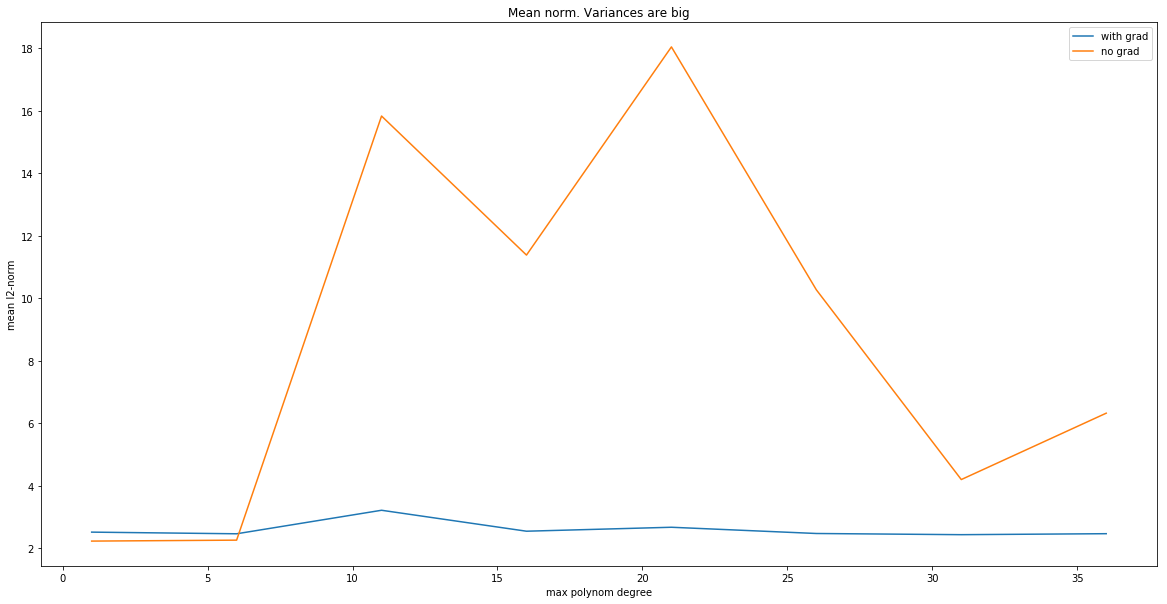

In [27]:
plt.figure(figsize=(20,10))
sample_size = 50
mean_with_grad_res = []
mean_no_grad_res = []
var_with_grad_res = []
var_no_grad_res = []
p_counts = np.arange(1, 40, 5)
for p_count in p_counts:
    print(p_count, end=',')
    mean_with_grad, mean_no_grad, var_with_grad, var_no_grad = get_mean_l2_norm(sample_size, p_count)
    mean_with_grad_res.append(mean_with_grad)
    mean_no_grad_res.append(mean_no_grad)
    var_with_grad_res.append(var_with_grad)
    var_no_grad_res.append(var_no_grad)

plt.title('Mean norm. Variances are big')
plt.plot(p_counts, mean_with_grad_res, label='with grad')
plt.plot(p_counts, mean_no_grad_res, label='no grad')
plt.xlabel('max polynom degree')
plt.ylabel('mean l2-norm')
plt.legend()
plt.show()